# Marketing Solution for Commercial Banking
ClearWater Associates

## Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('bank-additional-full.csv', delimiter=';')

In [4]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

y - has the client subscribed a term deposit? (binary: 'yes', 'no')

41,188 samples in total.

In [5]:
df = df.rename(columns={'y': 'label'})
df['label'].value_counts()

no     36548
yes     4640
Name: label, dtype: int64

In [6]:
df = df.replace('unknown', np.nan)

<AxesSubplot: >

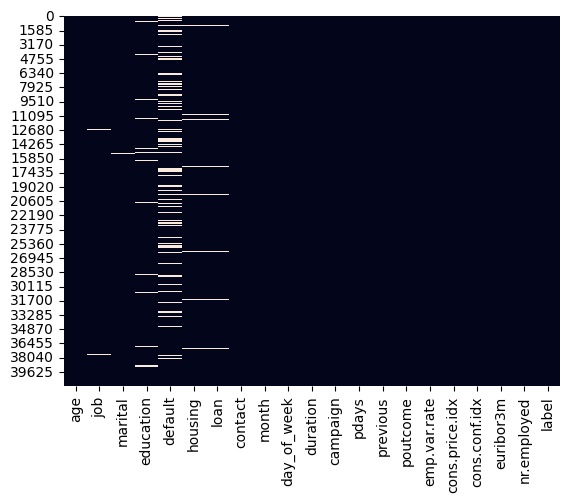

In [7]:
sns.heatmap(df.isnull(), cbar=False)

In [8]:
na_ratio = (df.isna().sum() / df.shape[0])
na_ratio = na_ratio[na_ratio > 0].sort_values(ascending=False)
na_ratio

default      0.208726
education    0.042027
housing      0.024036
loan         0.024036
job          0.008012
marital      0.001942
dtype: float64

`default`: has credit in default or not. This feature contains too many null values, so we decide to drop it.

In [9]:
df = df.drop('default', axis=1)

`duration`: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if `duration`=0 then `y`='no').
Yet, the duration is not known before a call is performed. Also, after the end of the call `y` is obviously known. Thus, this input should be discarded if the intention is to have a realistic predictive model.

In [10]:
df = df.drop('duration', axis=1)

The remaining null values only account for a small proportion (0.2\%-4.2\%) in the corresponding features, so we only drop the null observations.

In [11]:
df = df.dropna(axis=0)

In [12]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print(cat_cols)
cat_features = cat_cols[:-1]
print(cat_features)

['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'label']
['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [13]:
map_0 = {
    'no': 0,
    'yes': 1
}

map_contact = {
    'telephone': 0,
    'cellular': 1
}

map_poutcome = {
    'failure': -1,
    'nonexistent': 0,
    'success': 1
}

map_marital = {
    'single': 0,
    'married': 1,
    'divorced': 2
}

map_job = {
    'unemployed': 0,
    'student': 1,
    'self-employed': 2,
    'blue-collar': 3,
    'housemaid': 4,
    'services': 5,
    'technician': 6,
    'admin.': 7,
    'management': 8,
    'entrepreneur': 9,
    'retired': 10
}

map_education = {
    'illiterate': 0,
    'basic.4y': 1,
    'basic.6y': 2,
    'basic.9y': 3,
    'high.school': 4,
    'professional.course': 5,
    'university.degree': 6
}

map_month = {
    'jan': 1, 'feb': 2, 'mar': 3,
    'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9,
    'oct': 10, 'nov': 11, 'dec': 12
}

map_day_of_week = {
    'mon': 1,
    'tue': 2,
    'wed': 3,
    'thu': 4,
    'fri': 5
}

In [14]:
map_housing = map_0
map_loan = map_0
map_label = map_0

In [15]:
numerical_features = df.select_dtypes(exclude=['object']).columns.to_list()
print(numerical_features)

['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [16]:
X = pd.DataFrame()
X[numerical_features] = MinMaxScaler().fit_transform(df[numerical_features])

df = df.reset_index(drop=True)

for col in cat_cols:
    X[col] = df[col].map(globals()[f"map_{col}"])

In [17]:
# X.to_csv('data.csv')

In [18]:
# X = pd.read_csv('data.csv')

In [19]:
y = X['label']
X = X.drop('label', axis=1)

In [20]:
X.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,housing,loan,contact,month,day_of_week,poutcome
0,0.481481,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,4,1,1,0,0,0,5,1,0
1,0.493827,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,5,1,4,0,0,0,5,1,0
2,0.246914,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,5,1,4,1,0,0,5,1,0
3,0.283951,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,7,1,2,0,0,0,5,1,0
4,0.481481,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,5,1,4,0,1,0,5,1,0


In [21]:
y.value_counts()

0    33987
1     4258
Name: label, dtype: int64

38,245 samples after data cleansing.

## Feature Engineering

`f_classif` is a statistical method that measures the **correlation** between each feature and the target variable using an **ANOVA F-test**. It assumes that the features are normally distributed and that the variance of the target variable is the same for each feature. It is best suited for datasets with continuous features and a small number of categorical features.

`mutual_info_classif` is a non-parametric method that measures the **mutual information** between each feature and the target variable. It does not make any assumptions about the distribution of the features and can handle both continuous and categorical features. It is best suited for datasets with a large number of features or a large number of categorical features.

In [22]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

In [23]:
X_num_scoring = SelectKBest(f_classif, k='all').fit(X[numerical_features], y)

In [24]:
X_num_scores = pd.DataFrame({
    'Name': X_num_scoring.feature_names_in_,
    'Score': X_num_scoring.scores_
})

X_num_scores = X_num_scores.sort_values('Score', ascending=False)
X_num_scores

,Name,Score
8,nr.employed,5263.680901
2,pdays,4343.155383
7,euribor3m,3798.371777
4,emp.var.rate,3571.757845
3,previous,1966.716115
5,cons.price.idx,689.546307
1,campaign,162.847480
6,cons.conf.idx,101.398998
0,age,34.748220


According to the scores above, we believe the features 'campaign', 'cons.conf.idx', 'age' are insignificant.

In [25]:
X_cat_scoring = SelectKBest(mutual_info_classif, k='all').fit(X[cat_features], y)

In [26]:
X_cat_scores = pd.DataFrame({
    'Name': X_cat_scoring.feature_names_in_,
    'Score': X_cat_scoring.scores_
})

X_cat_scores = X_cat_scores.sort_values('Score', ascending=False)
X_cat_scores

,Name,Score
8,poutcome,0.028924
6,month,0.023105
5,contact,0.014806
0,job,0.009720
2,education,0.005805
3,housing,0.004526
1,marital,0.003594
7,day_of_week,0.001561
4,loan,0.000000


The feature with the lowest score is 'loan', which means having personal loan or not. Intuitively this shoule be related, so we don't drop any features here.

In [27]:
X = X.drop(['campaign', 'cons.conf.idx', 'age'], axis=1)

In [28]:
X.head()

,pdays,previous,emp.var.rate,cons.price.idx,euribor3m,nr.employed,job,marital,education,housing,loan,contact,month,day_of_week,poutcome
0,1.0,0.0,0.9375,0.698753,0.957379,0.859735,4,1,1,0,0,0,5,1,0
1,1.0,0.0,0.9375,0.698753,0.957379,0.859735,5,1,4,0,0,0,5,1,0
2,1.0,0.0,0.9375,0.698753,0.957379,0.859735,5,1,4,1,0,0,5,1,0
3,1.0,0.0,0.9375,0.698753,0.957379,0.859735,7,1,2,0,0,0,5,1,0
4,1.0,0.0,0.9375,0.698753,0.957379,0.859735,5,1,4,0,1,0,5,1,0


15 features selected.

In [29]:
X.describe()

,pdays,previous,emp.var.rate,cons.price.idx,euribor3m,nr.employed,job,marital,education,housing,loan,contact,month,day_of_week,poutcome
count,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000
mean,0.964496,0.024287,0.725596,0.533637,0.677692,0.770634,5.471748,0.831141,4.167342,0.538057,0.155811,0.639064,6.620081,2.977095,-0.070414
std,0.184480,0.069596,0.326239,0.224617,0.392252,0.271306,2.319776,0.604422,1.635449,0.498556,0.362681,0.480278,2.048797,1.410399,0.361195
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,-1.000000
25%,1.000000,0.000000,0.333333,0.340608,0.160961,0.512287,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000,5.000000,2.000000,0.000000
50%,1.000000,0.000000,0.937500,0.484412,0.957379,0.859735,6.000000,1.000000,4.000000,1.000000,0.000000,1.000000,6.000000,3.000000,0.000000
75%,1.000000,0.000000,1.000000,0.698753,0.980957,1.000000,7.000000,1.000000,6.000000,1.000000,0.000000,1.000000,8.000000,4.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,2.000000,6.000000,1.000000,1.000000,1.000000,12.000000,5.000000,1.000000


## Model Construction

In [30]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Preliminary model:

In [32]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      6797
           1       0.60      0.26      0.36       852

    accuracy                           0.90      7649
   macro avg       0.76      0.62      0.65      7649
weighted avg       0.88      0.90      0.88      7649



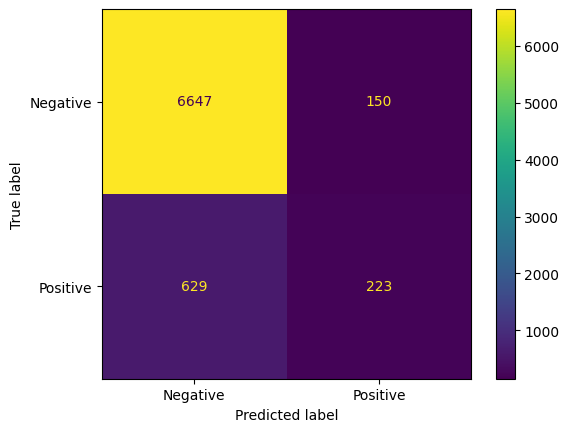

In [34]:
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

cm_display.plot()
plt.show()

([<matplotlib.patches.Wedge at 0x1be9b2ac250>,
 [Text(-0.3328619319868037, 1.0484287931156855, 'Successful Calls'),
  Text(0.332861833825814, -1.0484288242804642, 'Failed Calls')],
 [Text(-0.18156105381098384, 0.5718702507903738, '59.8%'),
  Text(0.18156100026862582, -0.571870267789344, '40.2%')])

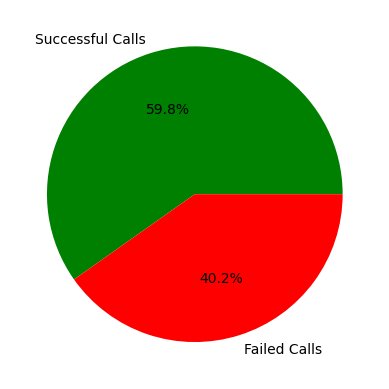

In [35]:
tp_fp_labels = ['Successful Calls', 'Failed Calls']
plt.pie(
    [cm.ravel()[3], cm.ravel()[1]],
    labels = ['Successful Calls', 'Failed Calls'],
    autopct='%1.1f%%',
    colors = ['green', 'red']
)

Tune the hyperparameters with 10-fold cross-validation in the training set.

In [36]:
param_grid = [{
    'max_depth': [2, 3, 6],
    'eta': [0.01, 0.05, 0.1]
}]

precision_scorer = make_scorer(precision_score, zero_division=0)

model_cv = GridSearchCV(
    xgb.XGBClassifier(random_state=42),
    param_grid=param_grid,
    cv=10,
    scoring=precision_scorer
)

In [37]:
model_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid=[{'eta': [0.01, 0.05, 0.1], 'max_depth': [2, 3, 6]}],
             scoring=make_scorer(precision_score, zero_division=0))

In [38]:
model_cv.best_score_

0.75974131146246

In [39]:
model_cv.best_params_

{'eta': 0.01, 'max_depth': 3}

In [40]:
model_best = model_cv.best_estimator_

In [41]:
y_best_pred = model_best.predict(X_test)
print(classification_report(y_test, y_best_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      6797
           1       0.78      0.13      0.23       852

    accuracy                           0.90      7649
   macro avg       0.84      0.56      0.59      7649
weighted avg       0.89      0.90      0.87      7649



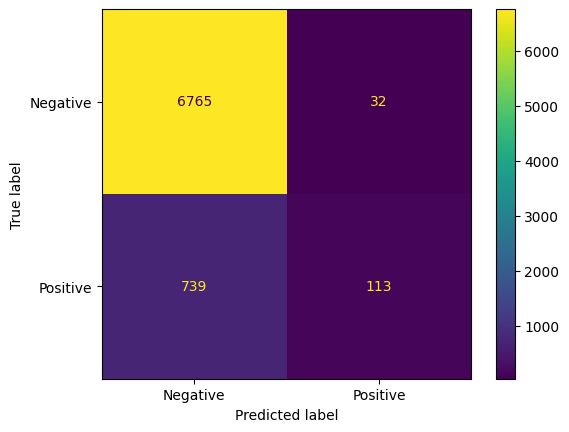

In [42]:
cm_best = confusion_matrix(y_test, y_best_pred)

cm_best_display = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=["Negative", "Positive"])

cm_best_display.plot()
plt.show()

([<matplotlib.patches.Wedge at 0x1be9b298e10>,
 [Text(-0.8460434226775078, 0.7030010860191668, 'Successful Calls'),
  Text(0.8460434226775078, -0.7030010860191669, 'Failed Calls')],
 [Text(-0.46147823055136783, 0.3834551378286364, '77.9%'),
  Text(0.46147823055136783, -0.38345513782863644, '22.1%')])

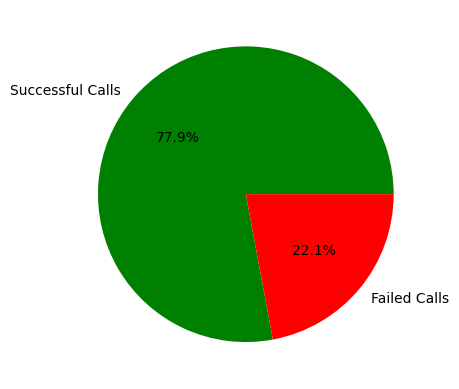

In [43]:
tp_fp_labels = ['Successful Calls', 'Failed Calls']
plt.pie(
    [cm_best.ravel()[3], cm_best.ravel()[1]],
    labels = ['Successful Calls', 'Failed Calls'],
    autopct='%1.1f%%',
    colors = ['green', 'red']
)